# Imports

In [1]:
import os
import h5py
import sympy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math
from scipy.interpolate import CubicSpline

from tree import SVTree
from nodes import FunctionNode
from regressor import SVRegressor

# Setup

In [2]:
basePath = os.path.join('results', 'smeam_dup')
fromArchive = False

basePath = os.path.join('results', 'mo_smooth2')
fromArchive = True

In [3]:
if fromArchive:
    allTreeNames = glob.glob(os.path.join(basePath, '*'))
    del allTreeNames[allTreeNames.index(os.path.join(basePath, 'archive.pkl'))]
    
    bestCost = np.inf
    bestIdx = 0
    
    worstCost = 0
    worstIdx = 0
    
    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    
    allErrors = []
    allLatex = []

    for i, treePath in enumerate(allTreeNames):
        treeName = os.path.split(treePath)[-1]
        
        tree = pickle.load(open(os.path.join(treePath, 'tree.pkl'), 'rb'))

        entry = archive[treeName]
        tree.bestParams = entry.bestParams

        errors = entry.bestErrors
    
        latex = SVTree([
            FunctionNode(n.description) if isinstance(n, FunctionNode)
            else n
            for n in tree.nodes
        ]).latex()

        sumErrors = np.sum(errors)
        
        if sumErrors < bestCost:
            print(sumErrors, bestCost)
            bestCost = sumErrors
            bestIdx = i
        
        if sumErrors > worstCost:
            worstCost = sumErrors
            worstIdx = i
        
        allErrors.append(sumErrors)
        allLatex.append(latex)
        
    allLatex = np.array(allLatex)[np.argsort(allErrors)]
    allErrors = np.array(allErrors)[np.argsort(allErrors)]

    for latex, errors in zip(allLatex, allErrors):
        display(Math('{:.2f}<->{}'.format(
            errors,
            sympy.latex(sympy.sympify(latex, evaluate=False), mul_symbol='dot')
        )))
            
    treePath = allTreeNames[bestIdx]
#     treePath = allTreeNames[worstIdx]
    treeName = os.path.split(treePath)[-1]

    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    tree = pickle.load(open(os.path.join(basePath, treeName, 'tree.pkl'), 'rb'))
    
    entry = archive[treeName]
    tree.bestParams = entry.bestParams
    
    errors = entry.bestErrors
else:
    files = sorted(glob.glob(os.path.join(basePath, 'tree*')))
    intIndices = [int(s[s.find('tree')+5:s.find('.pkl')]) for s in files]

    argsort = np.argsort(intIndices)

    treeFile = np.array(files)[argsort][-1]
    tree = pickle.load(open(treeFile, 'rb'))
    
    errorFiles = sorted(glob.glob(os.path.join(basePath, 'errors*')))
    errorFile  = np.array(errorFiles)[argsort][-1]
    errors = pickle.load(open(errorFile, 'rb'))

78.77787188581301 inf


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
allErrors[bestIdx]

78.77787188581301

# Plotting

In [5]:
def plotSpline(x, y, bc):
    cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
    
    plotX = np.linspace(x[0]-0.1, x[-1]+0.1, 100)
    plotY = cs(plotX)
    
    return plotX, plotY

In [6]:
splits = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+len(svNode.restrictions[comp]))

In [7]:
splitParams = np.array_split(tree.fillFixedKnots(tree.bestParams)[0], np.cumsum(splits)[:-1])

<IPython.core.display.Math object>

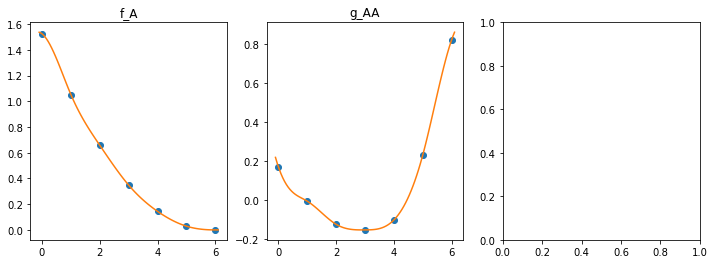

In [8]:
numRows = int(max(1, np.ceil(len(splitParams)/3)))

fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

compNames = np.hstack([svNode.components for svNode in tree.svNodes])

display(Math('{}'.format(
    sympy.latex(sympy.sympify(allLatex[0], evaluate=False), mul_symbol='dot')
)))
    
for i, spline in enumerate(splitParams):
    y, bc = spline[:-2], spline[-2:]
    x = np.arange(len(y))
    
    plotX, plotY = plotSpline(x, y, bc)
    
    row = i//3
    col = i%3
    
    if numRows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
    
    ax.plot(x, y, 'o')
    ax.plot(plotX, plotY)
    ax.set_title(compNames[i].decode('utf-8'))

# Errors

## Directly from logs

In [21]:
energyWeight = 1
forcesWeight = 1

unweighted = errors.copy()
unweighted[::2] /= energyWeight
unweighted[1::2] /= forcesWeight

np.sqrt(np.average(unweighted**2))

0.33506613908759086

In [22]:
with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
        
    print(
        '{:>45} average errors || {:.6f} {:.6f}\n'.format(
            str(tree),
            np.sqrt(np.average(unweighted[::2]**2)),
            np.sqrt(np.average(unweighted[1::2]**2)),
        )
    )
    
    print(
        '{:>60} || {} {}'.format(
            'structName',
            '(eV/atom)',
            '(eV/A)'
        )
    )
    
    for i, structName in enumerate(sorted(db)):
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                unweighted[2*i],
                unweighted[2*i+1]
            )
        )

                                          ffg average errors || 0.073472 0.468125

                                                  structName || (eV/atom) (eV/A)
                                        Ground_state_crystal || 0.000000 0.041492
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.013005 0.037592
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.036736 0.040078
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.069090 0.039750
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.108952 0.039201
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.156244 0.042046
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.001161 0.042112
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.066100 0.042391
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.012929 0.035582
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.036728 0.038874
                

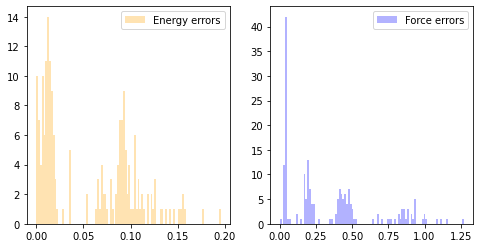

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(errors[::2] , bins=100, alpha=0.3, label='Energy errors', color='orange')
ax[1].hist(errors[1::2], bins=100, alpha=0.3, label='Force errors', color='blue')

ax[0].legend()
ax[1].legend()

## External validation

In [12]:
tree.bestParams.shape

(16,)

In [13]:
popDict = tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)

for svName in popDict:
    for bondType in popDict[svName]:
        popDict[svName][bondType] = [popDict[svName][bondType]]

In [14]:
def buildSVNodePool(group):
    """Prepare svNodePool for use in tree construction"""

    svNodePool = []

    # `group` is a pointer to an entry for a structure in the database
    for svName in sorted(group):
        svGroup = group[svName]

        restrictions = None
        if 'restrictions' in svGroup.attrs:
            restrictions = []
            resList = svGroup.attrs['restrictions'].tolist()
            for num in svGroup.attrs['numRestrictions']:
                tmp = []
                for _ in range(num):
                    tmp.append(tuple(resList.pop()))
                restrictions.append(tmp)

        svNodePool.append(
            SVNode(
                description=svName,
                components=svGroup.attrs['components'],
                numParams=svGroup.attrs['numParams'],
                bonds={
                    k:svGroup[k].attrs['components'] for k in svGroup.keys()
                },
                restrictions=restrictions,
                paramRanges=svGroup.attrs['paramRanges']\
                    if 'paramRanges' in group[svName].attrs else None
            )
        )

    return svNodePool

In [15]:
import cma

from mpi4py import MPI

from nodes import SVNode
from settings import Settings
from database import SVDatabase
from evaluator import SVEvaluator
from regressor import SVRegressor

settingsPath = 'examples/settings.in'
databasePath = '../svreg_data/mlearn/Mo/Mo.hdf5'

settings = Settings.from_file(settingsPath)
settings['PROCS_PER_PHYS_NODE'] = 1
settings['PROCS_PER_MANAGER'] = 1

worldComm = MPI.COMM_WORLD
with SVDatabase(settings['databasePath'], 'r') as database:
    structNames = list(database.keys())
#     structNames = ['Ground_state_crystal']

    if settings['refStruct'] not in structNames:
        raise RuntimeError(
            "The reference structure must be included in structNames."
        )

    evaluator =  SVEvaluator(worldComm, structNames, settings)
    evaluator.distributeDatabase(database)

    trueValues = database.loadTrueValues()

#     numStructs = len(trueValues)
    
    refStruct = settings['refStruct']
    treeErrors = np.zeros(2*len(database))
    
    svNodePool = buildSVNodePool(database[settings['refStruct']])
    
    regressor = SVRegressor(
        settings, svNodePool, cma.CMAEvolutionStrategy, [1.0, {'popsize': 1}]
    )
    
    regressor.trees = [tree]
    
    treePopulations = [tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)]
    
    # Group all dictionaries into one
    populationDict = {}
    for svNode in svNodePool:
        populationDict[svNode.description] = {}
        for bondType in svNode.bonds:
            populationDict[svNode.description][bondType] = []

    for treeDict in treePopulations:
        for svName in treeDict.keys():
            for bondType, pop in treeDict[svName].items():
                populationDict[svName][bondType].append(pop)
                            
    svEng = evaluator.evaluate(populationDict, evalType='energy')
    svFcs = evaluator.evaluate(populationDict, evalType='forces')
    
    energies, forces = regressor.evaluateTrees(svEng, svFcs, 1)
    
    for structName in sorted(structNames):
        eng = energies[structName][0] - energies[refStruct][0]
        fcs =   forces[structName][0]
        
        engErrors = eng - trueValues[structName]['energy']
        fcsErrors = fcs - trueValues[structName]['forces']
        
        treeErrors[2*i]   = abs(engErrors)
        treeErrors[2*i+1] = np.average(np.abs(fcsErrors), axis=(1, 2))
        
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                treeErrors[2*i],
                treeErrors[2*i+1]
            )
        )
# del evaluator

                                        Ground_state_crystal || 0.000000 0.041492
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.013005 0.037592
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.036736 0.040078
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.069090 0.039750
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.108952 0.039201
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.156244 0.042046
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.001161 0.042112
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.066100 0.042391
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.012929 0.035582
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.036728 0.038874
                         Mo_3x3x3_cell_mode_2_strain_-0.0600 || 0.069216 0.041709
                         Mo_3x3x3_cell_mode_2_strain_-0.0800 || 0.108899 0.038774
                

In [16]:
treeErrors.sum()

1.0307281294910198

In [17]:
del evaluator

In [18]:
from scipy.special import erf

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


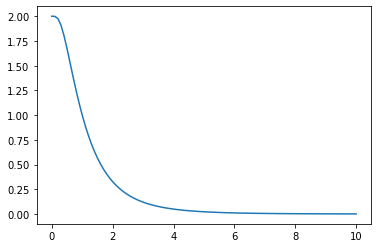

In [19]:
fig, ax = plt.subplots()

x = np.linspace(0, 10, 100)
ax.plot(x, 1-erf(np.log(x)))

In [20]:
1-erf(np.log(x))

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([2.00000000e+00, 1.99881362e+00, 1.97629491e+00, 1.90867730e+00,
       1.80002313e+00, 1.66597825e+00, 1.52118092e+00, 1.37600848e+00,
       1.23685949e+00, 1.10722126e+00, 9.88659792e-01, 8.81551842e-01,
       7.85579776e-01, 7.00050408e-01, 6.24093620e-01, 5.56782297e-01,
       4.97201968e-01, 4.44488927e-01, 3.97848925e-01, 3.56564155e-01,
       3.19993391e-01, 2.87568330e-01, 2.58787995e-01, 2.33212354e-01,
       2.10455803e-01, 1.90180917e-01, 1.72092635e-01, 1.55932998e-01,
       1.41476443e-01, 1.28525632e-01, 1.16907805e-01, 1.06471578e-01,
       9.70841656e-02, 8.86289679e-02, 8.10034728e-02, 7.41174426e-02,
       6.78913431e-02, 6.22549816e-02, 5.71463281e-02, 5.25104931e-02,
       4.82988410e-02, 4.44682204e-02, 4.09802950e-02, 3.78009622e-02,
       3.48998459e-02, 3.22498552e-02, 2.98267981e-02, 2.76090449e-02,
       2.55772333e-02, 2.37140095e-02, 2.20038018e-02, 2.04326211e-02,
       1.89878862e-02, 1.76582690e-02, 1.64335587e-02, 1.53045418e-02,
      